In [5]:
from glob import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
%matplotlib inline

In [ ]:
path_datasets = "datasets/"
root_path = "telefonica/shared/"

all_files = glob(path_datasets + "[0-9]*/" + root_path + "*.CSV")
all_files

In [5]:
dtype = {
    'CODIGOENTIDAD': 'category',
    'NOMBREENTIDAD': 'category',
    'CODIGOSITIO': 'category',
    'NOMBRESITIO': 'category',
    'NROTARJETA': 'category'
}

## With `pandas`

In [6]:
%%time
df = (pd.read_csv(f, sep=";", encoding="cp1252", usecols=[i for i in range(6)], dtype=dtype) for f in all_files)
df = pd.concat(df, ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54583158 entries, 0 to 54583157
Data columns (total 6 columns):
FECHAHORATRX     object
CODIGOENTIDAD    category
NOMBREENTIDAD    category
CODIGOSITIO      object
NOMBRESITIO      object
NROTARJETA       object
dtypes: category(2), object(4)
memory usage: 1.7+ GB
CPU times: user 6min 59s, sys: 14.6 s, total: 7min 13s
Wall time: 7min 15s


In [7]:
%%time
df["FECHAHORATRX"] = pd.to_datetime(df["FECHAHORATRX"], format="%d/%m/%Y %H:%M:%S", errors='coerce')
df.set_index("FECHAHORATRX", inplace=True)

CPU times: user 2min 43s, sys: 1.58 s, total: 2min 45s
Wall time: 2min 45s


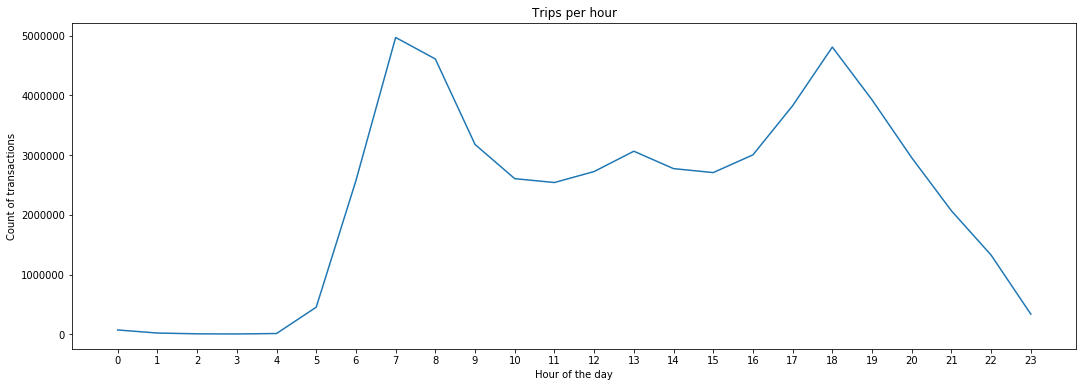

In [9]:
hour_count = df.groupby(df.index.hour).count()['CODIGOENTIDAD']
_ = plt.figure(figsize=(18, 6))
_ = plt.plot(hour_count)
_ = plt.title("Trips per hour")
_ = plt.xlabel('Hour of the day')
_ = plt.ylabel('Count of transactions')
_ = plt.xticks(hour_count.index, hour_count.index)

In [29]:
df.groupby(df.index.date).count()

CODIGOENTIDAD  NOMBREENTIDAD  CODIGOSITIO  NOMBRESITIO  NROTARJETA
2018-09-01             14             14           14           14          14
2019-01-17              4              4            4            4           4
2019-01-28            208            208          208          208         208
2019-01-29             58             58           58           58          58
2019-01-30             77             77           77           77          77
2019-01-31             54             54           54           54          54
2019-02-01             79             79           79           79          79
2019-02-02              5              5            5            5           5
2019-02-03             30             30           30           30          30
2019-02-06             42             42           42           42          42
2019-02-12            134            134          134          134         134
2019-02-18            206            206          206          206         206
2019-02-19            347            347          347          347         347
2019-02-20            398            398          398          398         398
2019-02-21            672            672          672          672         672
2019-02-22            466            466          466          466         466
2019-02-23           1199           1199         1199         1199        1199
2019-02-24           1351           1351         1351         1351        1351
2019-02-25           5983           5983         5983         5983        5983
2019-02-26          13751          13751        13751        13751       13751
2019-02-27          27316          27316        27316        27316       27316
2019-02-28          69075          69075        69075        69075       69075
2019-03-01        3057606        3057606      3057606      3057606     3057606
2019-03-02        2825863        2825863      2825863      2825863     2825863
2019-03-03        1781627        1781627      1781627      1781627     1781627
2019-03-04        5407456        5407456      5407456      5407456     5407456
2019-03-05        5470157        5470157      5470157      5470157     5470157
2019-03-06        5453699        5453699      5453699      5453699     5453699
2019-03-07        2160132        2160132      2160132      2160132     2160132
2019-03-08            531            531          531          531         531
2019-03-09            299            299          299          299         299
2019-03-10            217            217          217          217         217
2019-03-11           1921           1921         1921         1921        1921
2019-03-12           2224           2224         2224         2224        2224
2019-03-13           1704           1704         1704         1704        1704
2019-03-14           3828           3828         3828         3828        3828
2019-03-15           4868           4868         4868         4868        4868
2019-03-16           4428           4428         4428         4428        4428
2019-03-17           3350           3350         3350         3350        3350
2019-03-18          20818          20818        20818        20818       20818
2019-03-19          66402          66402        66402        66402       66402
2019-03-20        3631278        3631278      3631278      3631278     3631278
2019-03-21        5861391        5861391      5861391      5861391     5861391
2019-03-22        5939144        5939144      5939144      5939144     5939144
2019-03-23        2982960        2982960      2982960      2982960     2982960
2019-03-24        1701007        1701007      1701007      1701007     1701007
2019-03-25        5808581        5808581      5808581      5808581     5808581
2019-03-26        2270198        2270198      2270198      2270198     2270198

CPU times: user 43.8 s, sys: 7.52 s, total: 51.3 s
Wall time: 1min 1s


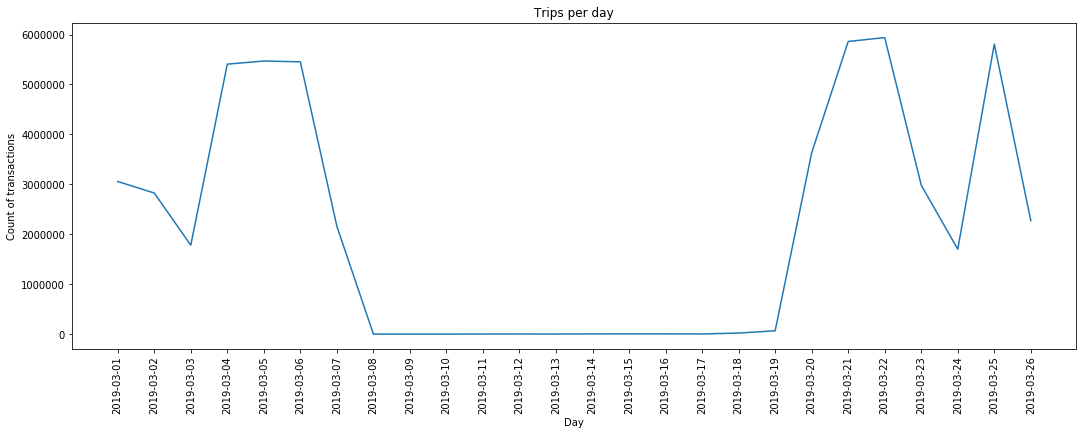

In [16]:
%%time
dates_count = df["2019-03"].groupby(df["2019-03"].index.date).count()['CODIGOENTIDAD']
_ = plt.figure(figsize=(18, 6))
_ = plt.plot(dates_count)
_ = plt.title("Trips per day")
_ = plt.xlabel('Day')
_ = plt.ylabel('Count of transactions')
_ = plt.xticks(dates_count.index, dates_count.index, rotation=90)

## With `pyspark`

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SQLContext
from pyspark.sql.types import Row, StructField, StructType, StringType, IntegerType, TimestampType
from pyspark.sql.functions import col, udf, hour, to_timestamp
from datetime import datetime

In [3]:
conf = SparkConf().setMaster("local[4]").setAppName("transport")
sc = SparkContext(conf=conf)

In [4]:
sqlContext = SQLContext(sc)
sqlContext

In [18]:
%%time
df = sqlContext.read.csv(path=all_files, header=True, sep=';', encoding="cp1252")
type(df)

CPU times: user 5.94 ms, sys: 0 ns, total: 5.94 ms
Wall time: 172 ms


In [19]:
df = df.drop('_c6')
df.printSchema()

root
 |-- FECHAHORATRX: string (nullable = true)
 |-- CODIGOENTIDAD: string (nullable = true)
 |-- NOMBREENTIDAD: string (nullable = true)
 |-- CODIGOSITIO: string (nullable = true)
 |-- NOMBRESITIO: string (nullable = true)
 |-- NROTARJETA: string (nullable = true)



In [20]:
%%time
df.count()

CPU times: user 2.58 ms, sys: 0 ns, total: 2.58 ms
Wall time: 12.8 s


54583158

In [12]:
df.show()

+-------------------+-------------+------------------+-----------+-----------+--------------------+
|       FECHAHORATRX|CODIGOENTIDAD|     NOMBREENTIDAD|CODIGOSITIO|NOMBRESITIO|          NROTARJETA|
+-------------------+-------------+------------------+-----------+-----------+--------------------+
|01/03/2019 00:02:40|           16|         U3 - Vule|      15065|    BJFT-91|87b432e59e18c8f4a...|
|01/03/2019 00:07:19|            5|U5 - Metropolitana|      14243|    BJFH-23|7878d84c3be9ef45b...|
|01/03/2019 00:07:26|            5|U5 - Metropolitana|      14243|    BJFH-23|c5e05fad6e3e25a21...|
|01/03/2019 00:08:33|           16|         U3 - Vule|      15065|    BJFT-91|c41067a66df51bde8...|
|01/03/2019 00:17:00|            5|U5 - Metropolitana|      14243|    BJFH-23|f1afa35f3b2f77460...|
|01/03/2019 00:17:02|            5|U5 - Metropolitana|      14243|    BJFH-23|7719c518903edadf1...|
|01/03/2019 00:23:23|            5|U5 - Metropolitana|      14243|    BJFH-23|e1abefb4651d01553...|


In [13]:
df.groupby('CODIGOENTIDAD').count().show()

+-------------+--------+
|CODIGOENTIDAD|   count|
+-------------+--------+
|           16| 6115833|
|            5| 6535914|
|           17|  732051|
|            9| 2670049|
|            1|24969163|
|            4| 5942283|
|           13| 3281896|
|            2| 4335969|
+-------------+--------+



In [14]:
%%time
df.groupby('NOMBREENTIDAD').count().show()

+------------------+--------+
|     NOMBREENTIDAD|   count|
+------------------+--------+
|       U2 - Su Bus| 4335969|
|          U7 - STP| 2670049|
|        METRO - OT|24969163|
|      Tren Central|  732051|
|       U6 - Redbus| 3281896|
|         U3 - Vule| 6115833|
|      U4 - Express| 5942283|
|U5 - Metropolitana| 6535914|
+------------------+--------+

CPU times: user 6.27 ms, sys: 689 Âµs, total: 6.96 ms
Wall time: 39.2 s


In [15]:
convert_date =  udf(lambda x: datetime.strptime(x, "%d/%m/%Y %H:%M:%S"), TimestampType())
df = df.withColumn('date_time', convert_date(col('FECHAHORATRX'))).drop("FECHAHORATRX")

In [19]:
df.printSchema()

root
 |-- CODIGOENTIDAD: string (nullable = true)
 |-- NOMBREENTIDAD: string (nullable = true)
 |-- CODIGOSITIO: string (nullable = true)
 |-- NOMBRESITIO: string (nullable = true)
 |-- NROTARJETA: string (nullable = true)
 |-- date_time: timestamp (nullable = true)



In [16]:
df.select(df["date_time"]).show(5)

+-------------------+
|          date_time|
+-------------------+
|2019-03-01 00:02:40|
|2019-03-01 00:07:19|
|2019-03-01 00:07:26|
|2019-03-01 00:08:33|
|2019-03-01 00:17:00|
+-------------------+
only showing top 5 rows



In [18]:
df.groupBy(hour("date_time")).agg({"date_time": "count"}).show()

+---------------+----------------+
|hour(date_time)|count(date_time)|
+---------------+----------------+
|             12|         2725040|
|             22|         1326820|
|              1|           22849|
|             13|         3065000|
|              6|         2572870|
|             16|         3004000|
|              3|            7221|
|             20|         2955978|
|              5|          455469|
|             19|         3924819|
|             15|         2707414|
|              9|         3178443|
|             17|         3826108|
|              4|           14748|
|              8|         4608828|
|             23|          338691|
|              7|         4968339|
|             10|         2605778|
|             21|         2068354|
|             11|         2541260|
+---------------+----------------+
only showing top 20 rows



In [15]:
df = df.withColumn('date_time', to_timestamp(df["FECHAHORATRX"])).drop("FECHAHORATRX")

In [31]:
df = df.withColumn('date_time', to_timestamp(df["FECHAHORATRX"], format="dd/MM/yyyy HH:mm:ss")).drop("FECHAHORATRX")

In [32]:
hou
df.show()

+-------------+------------------+-----------+-----------+--------------------+-------------------+
|CODIGOENTIDAD|     NOMBREENTIDAD|CODIGOSITIO|NOMBRESITIO|          NROTARJETA|          date_time|
+-------------+------------------+-----------+-----------+--------------------+-------------------+
|           16|         U3 - Vule|      15065|    BJFT-91|87b432e59e18c8f4a...|2019-03-01 00:02:40|
|            5|U5 - Metropolitana|      14243|    BJFH-23|7878d84c3be9ef45b...|2019-03-01 00:07:19|
|            5|U5 - Metropolitana|      14243|    BJFH-23|c5e05fad6e3e25a21...|2019-03-01 00:07:26|
|           16|         U3 - Vule|      15065|    BJFT-91|c41067a66df51bde8...|2019-03-01 00:08:33|
|            5|U5 - Metropolitana|      14243|    BJFH-23|f1afa35f3b2f77460...|2019-03-01 00:17:00|
|            5|U5 - Metropolitana|      14243|    BJFH-23|7719c518903edadf1...|2019-03-01 00:17:02|
|            5|U5 - Metropolitana|      14243|    BJFH-23|e1abefb4651d01553...|2019-03-01 00:23:23|


In [36]:
%%time
hours = df.groupBy(hour("date_time")).agg({"date_time": "count"}).toPandas()

CPU times: user 15.5 ms, sys: 2.26 ms, total: 17.7 ms
Wall time: 1min 9s


In [38]:
hours.rename(columns={"hour(date_time)": "hour", "count(date_time)": "count"}, inplace=True)

In [39]:
hours

hour    count
0     12  2725040
1     22  1326820
2      1    22849
3     13  3065000
4      6  2572870
5     16  3004000
6      3     7221
7     20  2955978
8      5   455469
9     19  3924819
10    15  2707414
11     9  3178443
12    17  3826108
13     4    14748
14     8  4608828
15    23   338691
16     7  4968339
17    10  2605778
18    21  2068354
19    11  2541260
20    14  2773796
21     2     9714
22     0    74139
23    18  4807480

In [42]:
hours.sort_values("hour", inplace=True)

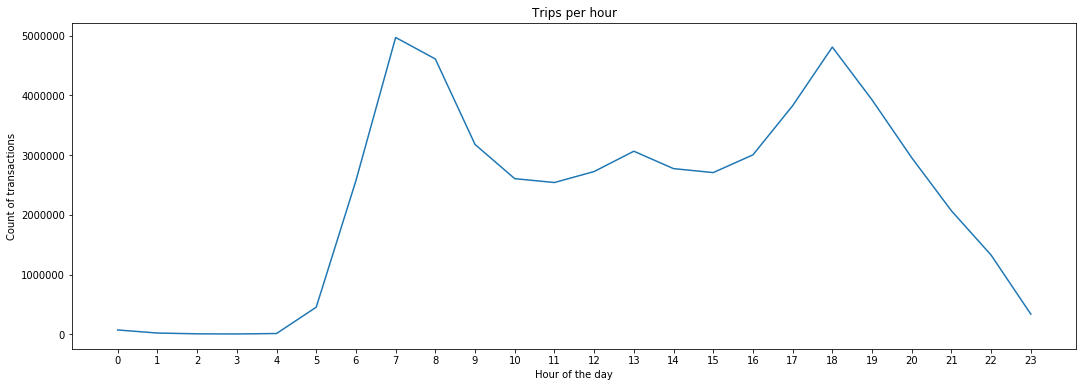

In [44]:
_ = plt.figure(figsize=(18, 6))
_ = plt.plot(hours['hour'], hours['count'])
_ = plt.title("Trips per hour")
_ = plt.xlabel('Hour of the day')
_ = plt.ylabel('Count of transactions')
_ = plt.xticks(hours['hour'], hours['hour'])